In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import seaborn as sns
from datetime import datetime

!pip install shap
import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

!pip install dtreeviz
import dtreeviz
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

import statsmodels as sm

import random
import joblib
import warnings

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [5]:
df = pd.read_csv("travel_survey.csv", sep = ";", encoding = "ISO-8859-1", index_col=0)

In [403]:
df.sample(5)

,Income,Gender,Age,Occupation,Education,HouseHoldSize,HouseHold16,driversLicense,carAvail,OriginLoc,DestLoc,startActiv,endActiv,mode,TripDay,realTravelTime.Walk,realShortestDistance.Walk,realTravelTime.Car,realShortestDistance.Car,realTravelTime.Bus,realShortestDistance.Bus,realTransfer.Bus,realAccessWalkTime.Bus,realAccessWalkDist.Bus,realEgressWalkTime.Bus,realEgressWalkDist.Bus,trip_duration_mins,sin_time,cos_time
6209,<10000,Female,65+,Retired,Lyceum,4,4,1,1,4,5,ChangeMode,Home,Car,Thursday,5781,7655,683,7745,773,7745,1,712,7363,61,87,15,-0.518773,-0.854912
3324,ÄÎ/ÄÁ,Female,16-24,Student,Lyceum,3,3,0,1,3,4,Home,School,Bus,Monday,2258,3084,769,3999,1408,3999,1,241,326,240,321,20,-0.866025,-0.500000
1161,10000-20000,Female,25-34,Employed,University,5,5,1,1,2,3,Work,Home,Car,Tuesday,4135,5553,574,6923,2059,6923,1,1089,1569,354,508,15,-0.866025,-0.500000
1579,20000-30000,Male,65+,Retired,University,2,2,1,1,1,2,Home,OtherMeetings,Bus,Tuesday,3179,4371,560,4798,1858,4798,1,124,157,700,931,15,0.442289,-0.896873
112,20000-30000,Female,35-44,Employed,Lyceum,4,2,1,1,1,2,Home,Work,Car,Sunday,6475,8520,713,9836,2357,9836,2,61,88,124,164,25,0.965926,-0.258819


# NA values

In [7]:
is_na = []
for col in df.columns:
    if df[col].isna().sum() > 0:
        is_na.append((col, df[col].isna().sum()))
is_na

[('Education', 4),
 ('realWaitingTime.Bus', 6813),
 ('EdPrimary', 4),
 ('EdHighSchool', 4),
 ('EdLyceum', 4),
 ('EdUniversity', 4),
 ('EdMSc', 4),
 ('EdPhD', 4),
 ('EdNoEducation', 4),
 ('InZone', 6813)]

Droping every feature indexed to the right of 'realWaitingTime.Bus' since these have already been one hot encoded by someone else 

In [8]:
df.columns.get_loc("realWaitingTime.Bus")

38

In [9]:
df.drop(df.iloc[:, 38:90], inplace = True, axis = 1)

# Categorical Features

In [10]:
cat_features = []
for col in df.columns:
    if df[col].dtype =='object':
        cat_features.append((col, len(df[col].unique())))
cat_features

[('Income', 7),
 ('Gender', 2),
 ('Age', 6),
 ('Occupation', 6),
 ('Education', 8),
 ('startActiv', 16),
 ('endActiv', 16),
 ('tripStart_time', 223),
 ('tripEnd_time', 234),
 ('mode', 4),
 ('TripDay', 7)]

Processing categorical features 

In [11]:
df['Income'].value_counts()

10000-20000    2330
<10000         1611
ÄÎ/ÄÁ          1267
20000-30000    1072
30000-40000     332
40000-50000     106
>50000           95
Name: Income, dtype: int64

There are 1267 missing values in income. Probably individuals who didnt wasnt to disclose. We could train a model to predict them or encode as -1. Will come back later

In [12]:
df['mode'].value_counts()

Car     3459
Bus     2396
Walk     760
MrC      198
Name: mode, dtype: int64

Big class impalance for motorbike. In any case, we arent so interested in motorbike labels so can remove this data

In [14]:
df = df[df['mode'] != 'MrC']
df = df.drop(['realTravelTime.MrC', 'realShortestDistance.MrC', 'realTransfer.MrC'], axis=1)

Clearly start and end times should not be categories. Will process these features, creating new features which preserve the cyclic natures of time

## Datetime

In [15]:
df['tripStart_time'] = pd.to_datetime(df['tripStart_time'], format='%H:%M:%S') - pd.to_datetime(df['tripStart_time'], format='%H:%M:%S').dt.normalize()
df['tripEnd_time'] = pd.to_datetime(df['tripEnd_time'], format='%H:%M:%S') - pd.to_datetime(df['tripEnd_time'], format='%H:%M:%S').dt.normalize()

In [16]:
df_time = df[['tripStart_time', 'tripEnd_time']].copy()

In [17]:
df_time['trip_duration'] =  (df_time['tripEnd_time'] - df_time['tripStart_time']).abs()

It looks like some of the start and end times have been filled in the wrong way round. Having a closer look

In [18]:
df_time['trip_duration_mins'] = df_time['trip_duration'].astype('timedelta64[m]').astype(int)

In [19]:
df_time['seconds'] = df_time['tripStart_time'].dt.total_seconds()

Creating 2D features for time of day using sin and cosine transforms

In [20]:
seconds_in_day = 24*60*60

df_time['sin_time'] = np.sin(2*np.pi*df_time['seconds']/seconds_in_day)
df_time['cos_time'] = np.cos(2*np.pi*df_time['seconds']/seconds_in_day)

In [21]:
df_time.head(3)

,tripStart_time,tripEnd_time,trip_duration,trip_duration_mins,seconds,sin_time,cos_time
1,22:30:00,23:15:00,00:45:00,45,81000.0,-0.382683,0.923880
2,11:00:00,11:30:00,00:30:00,30,39600.0,0.258819,-0.965926
3,09:00:00,09:15:00,00:15:00,15,32400.0,0.707107,-0.707107


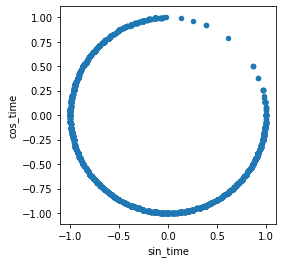

In [22]:
df_time.plot.scatter('sin_time','cos_time').set_aspect('equal')

Now our model has features which holds the cyclical nature of the 24 hour clock 

Merging these new features into our main dataframe and dropping original time features

In [23]:
df = pd.concat([df, df_time[['trip_duration_mins', 'sin_time', 'cos_time']]], axis=1)
df = df.drop(['tripStart_time', 'tripEnd_time', 'tripDuration'], axis=1)

## Trip day

In [24]:
df['TripDay'].value_counts()

ÐÝìðôç       1365
ÔåôÜñôç      1229
Ôñßôç        1084
ÐáñáóêåõÞ    1055
ÄåõôÝñá       815
ÓÜââáôï       694
ÊõñéáêÞ       373
Name: TripDay, dtype: int64

If I was to hazard a guess... I would say these are days of the week from Monday to Sunday 

In [25]:
days = {
    'ÐÝìðôç' : 'Monday',
    'ÔåôÜñôç' : 'Tuesday',   
    'Ôñßôç' : 'Wednesday',     
    'ÐáñáóêåõÞ' : 'Thursday',  
    'ÄåõôÝñá' : 'Friday', 
    'ÓÜââáôï' : 'Saturday',
    'ÊõñéáêÞ' : 'Sunday'
}

In [26]:
df['TripDay'] = df['TripDay'].map(days)

## Removing unrequired features

In [27]:
df = df.drop(['TripID', 'Questionnaire', 'Origin', 'Destination', 'realTransfer.Walk', 'realTransfer.Car', ], axis=1)

Changing car avaiability from boolean to 0 or 1

In [28]:
df['carAvail'] = df['carAvail'].astype(int)

In [29]:
df.head(5)

,Income,Gender,Age,Occupation,Education,HouseHoldSize,HouseHold16,driversLicense,carAvail,OriginLoc,DestLoc,startActiv,endActiv,mode,TripDay,realTravelTime.Walk,realShortestDistance.Walk,realTravelTime.Car,realShortestDistance.Car,realTravelTime.Bus,realShortestDistance.Bus,realTransfer.Bus,realAccessWalkTime.Bus,realAccessWalkDist.Bus,realEgressWalkTime.Bus,realEgressWalkDist.Bus,trip_duration_mins,sin_time,cos_time
1,<10000,Male,25-34,Unemployed,University,1,1,1,0,5,6,Leisure,Home,Walk,Tuesday,22553,30384,2618,33855,4155,2618,2,252,392,223,271,45,-0.382683,0.923880
2,<10000,Male,25-34,Unemployed,University,1,1,1,0,1,2,Home,School,Walk,Tuesday,21939,29438,2342,32801,4303,2342,2,176,271,286,315,30,0.258819,-0.965926
3,10000-20000,Male,65+,Retired,University,4,4,1,1,1,2,Home,Shopping,Walk,Monday,20059,27574,2211,36191,5240,2211,3,516,659,59,70,15,0.707107,-0.707107
4,<10000,Female,65+,Retired,HighSchool,1,1,1,0,2,3,OtherMeetings,Home,Walk,Saturday,14990,21078,1641,29175,4658,1641,3,1995,9824,529,702,55,-0.382683,-0.923880
5,ÄÎ/ÄÁ,Female,55-64,Retired,Lyceum,5,5,1,1,1,2,Home,PersonalActivities,Walk,Thursday,8324,11037,1067,12937,2739,1067,2,673,855,833,1069,75,0.707107,-0.707107


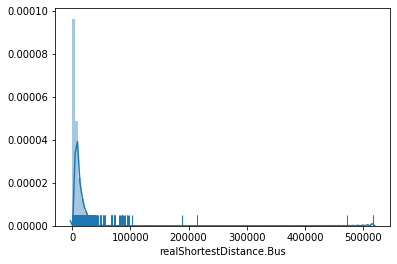

In [30]:
sns.distplot(df['realShortestDistance.Bus'], bins=100, rug=True)
plt.show()

Changing 4 nan values in education to strings

In [31]:
df['Education'] = df['Education'].replace(np.nan, 'N/A', regex=True)

In [32]:
#Removing four values from dataset which are far from sample mean, in any case, these values were easily classified as car trips
df = df[df['realShortestDistance.Car'] < 150000]

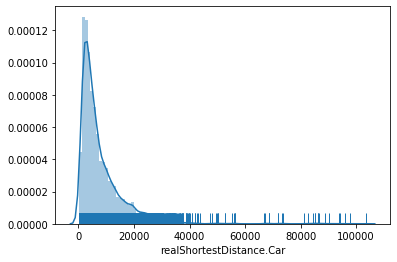

In [33]:
sns.distplot(df['realShortestDistance.Car'], bins=100, rug=True)
plt.show()

In [34]:
#shuffling dataset now rather than during test train split to make feature analysis easier later
random.seed(30)
df = df.sample(frac = 1).reset_index(drop=True).copy()

## Creating new dataframe of label encoded categories

In [35]:
df_encoded = df.copy()

In [36]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder()
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

Since we are using a tree based predictor we will encode missing values as -1 to split them off

In [37]:
income_label = {
    '<10000' : 0,
    '10000-20000' : 1,
    '20000-30000' : 2,
    '30000-40000' : 3,
    '40000-50000' : 4,
    '>50000' : 5,
    'ÄÎ/ÄÁ' : -1   
}

In [38]:
df_encoded['Income'] = df_encoded['Income'].map(income_label)

Same for education

In [39]:
df_encoded['Education'].value_counts()

University       2734
Lyceum           2665
HighSchool        463
PrimarySchool     328
MSc               316
PhD                88
NoEducation        11
N/A                 4
Name: Education, dtype: int64

In [40]:
education_label = {
    'University' : 0,
    'Lyceum' : 1,
    'HighSchool' : 2,
    'PrimarySchool' : 3,
    'MSc' : 4,
    'PhD' : 5,
    'NoEducation' : 6,
    'N/A' : -1
}

In [41]:
df_encoded['Education'] = df_encoded['Education'].map(education_label)

In [42]:
df_encoded = MultiColumnLabelEncoder(columns = ['Gender', 'Age', 'Occupation', 'startActiv', 'endActiv', 'TripDay', ]).fit_transform(df_encoded)

## Creating new dataframe of one hot encoded categories for linear models

In [43]:
df_one_hot = df.copy()

In [44]:
categories = ['Income', 'Gender', 'Age', 'Occupation', 'Education', 'startActiv', 'endActiv', 'TripDay']

one_hot = OneHotEncoder(categories='auto')
feature_arr = one_hot.fit_transform(df_one_hot[categories]).toarray()
features = pd.DataFrame(feature_arr, columns=one_hot.get_feature_names())

In [45]:
df_one_hot = pd.concat([df_one_hot.reset_index(drop=True), features.reset_index(drop=True)], axis=1) 
df_one_hot = df_one_hot.drop(categories, axis=1)

In [46]:
def renaming(x):
    if "<" in x:
        return x.replace('<', 'less_')
    elif ">" in x:
        return x.replace('>', 'gtr_')
    return x

df_one_hot = df_one_hot.rename(columns=renaming)

In [47]:
df_one_hot.head(2)

,HouseHoldSize,HouseHold16,driversLicense,carAvail,OriginLoc,DestLoc,mode,realTravelTime.Walk,realShortestDistance.Walk,realTravelTime.Car,realShortestDistance.Car,realTravelTime.Bus,realShortestDistance.Bus,realTransfer.Bus,realAccessWalkTime.Bus,realAccessWalkDist.Bus,realEgressWalkTime.Bus,realEgressWalkDist.Bus,trip_duration_mins,sin_time,cos_time,x0_10000-20000,x0_20000-30000,x0_30000-40000,x0_40000-50000,x0_less_10000,x0_gtr_50000,x0_ÄÎ/ÄÁ,x1_Female,x1_Male,x2_16-24,x2_25-34,x2_35-44,x2_45-54,x2_55-64,x2_65+,x3_Employed,x3_Houseworks,x3_Retired,x3_Student,x3_Unemployed,x3_Unemployed_other,x4_HighSchool,x4_Lyceum,x4_MSc,x4_N/A,x4_NoEducation,x4_PhD,x4_PrimarySchool,x4_University,x5_ChangeMode,x5_DropSomebody,x5_HealthActivities,x5_Home,x5_HomeWork,x5_HorkRelatedActivities,x5_Leisure,x5_Other,x5_OtherMeetings,x5_PersonalActivities,x5_PickSomebody,x5_STPersonalActivities(Gas),x5_School,x5_Shopping,x5_Sports,x5_Work,x6_ChangeMode,x6_DropSomebody,x6_HealthActivities,x6_Home,x6_HomeWork,x6_HorkRelatedActivities,x6_Leisure,x6_Other,x6_OtherMeetings,x6_PersonalActivities,x6_PickSomebody,x6_STPersonalActivities(Gas),x6_School,x6_Shopping,x6_Sports,x6_Work,x7_Friday,x7_Monday,x7_Saturday,x7_Sunday,x7_Thursday,x7_Tuesday,x7_Wednesday
0,5,5,1,1,4,5,Car,1505,1973,297,2271,964,2271,1,183,211,355,463,20,-0.751840,0.659346,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5,2,1,1,2,3,Car,4235,5931,1126,6651,2133,6651,1,1826,6542,307,411,20,-0.707107,-0.707107,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

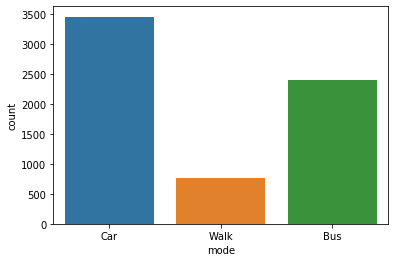

In [48]:
sns.countplot(df_encoded['mode'])
plt.show()

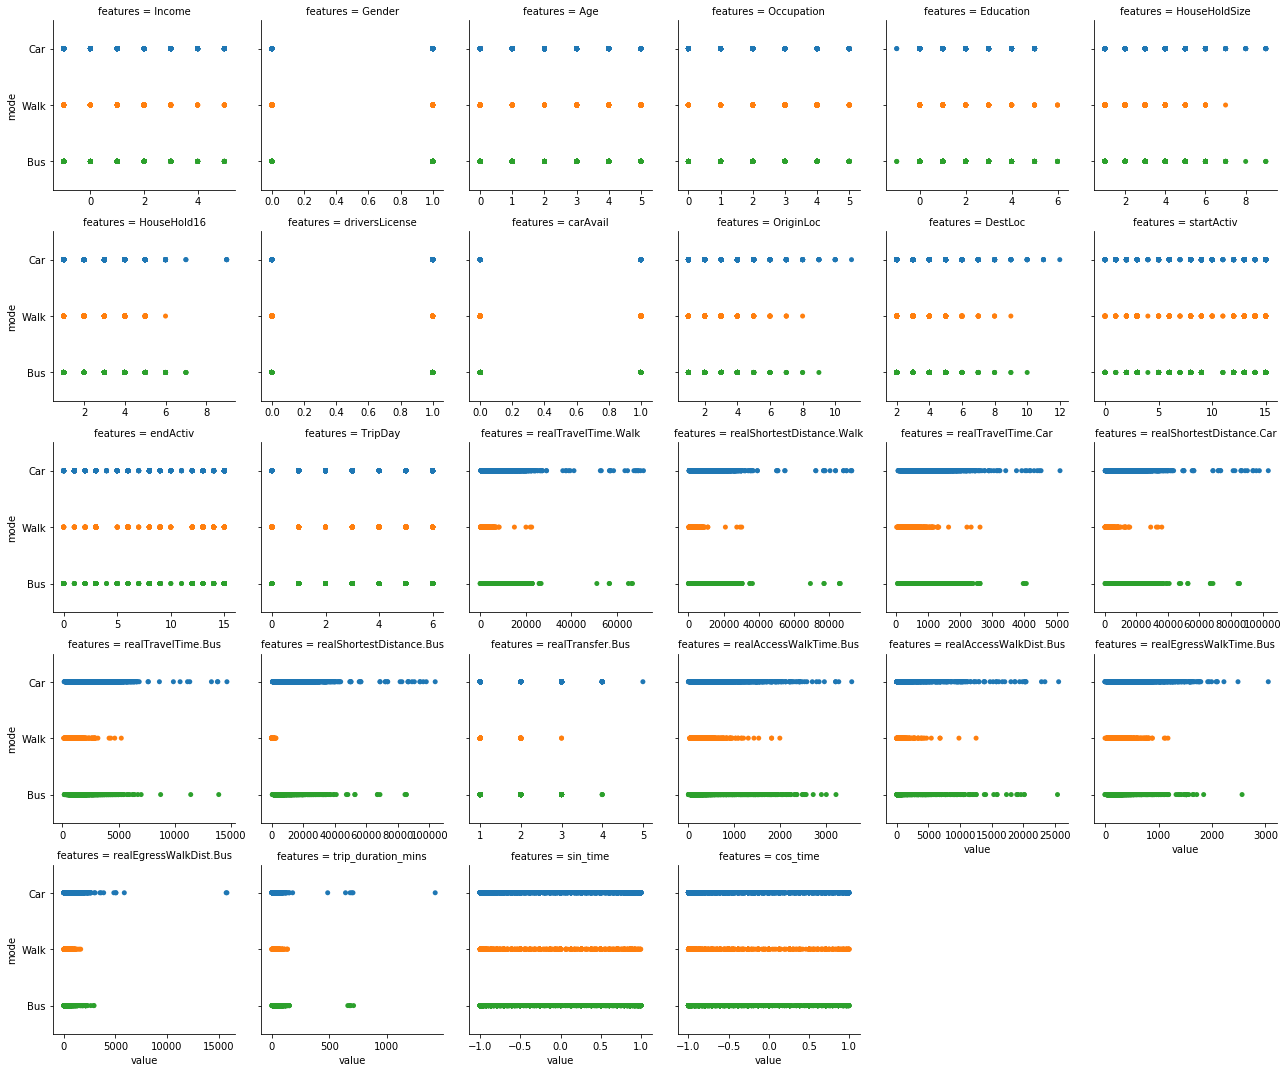

In [49]:
df_wide = df_encoded.melt(id_vars=['mode'], var_name='features')
sns.catplot(data=df_wide, x='value', y='mode', col='features', 
            col_wrap=6, 
            height=3, 
            aspect=1, 
            sharex=False,
            jitter=False)
plt.show()

In [50]:
df_encoded.head(1)

,Income,Gender,Age,Occupation,Education,HouseHoldSize,HouseHold16,driversLicense,carAvail,OriginLoc,DestLoc,startActiv,endActiv,mode,TripDay,realTravelTime.Walk,realShortestDistance.Walk,realTravelTime.Car,realShortestDistance.Car,realTravelTime.Bus,realShortestDistance.Bus,realTransfer.Bus,realAccessWalkTime.Bus,realAccessWalkDist.Bus,realEgressWalkTime.Bus,realEgressWalkDist.Bus,trip_duration_mins,sin_time,cos_time
0,1,1,1,4,2,5,5,1,1,4,5,9,3,Car,1,1505,1973,297,2271,964,2271,1,183,211,355,463,20,-0.75184,0.659346


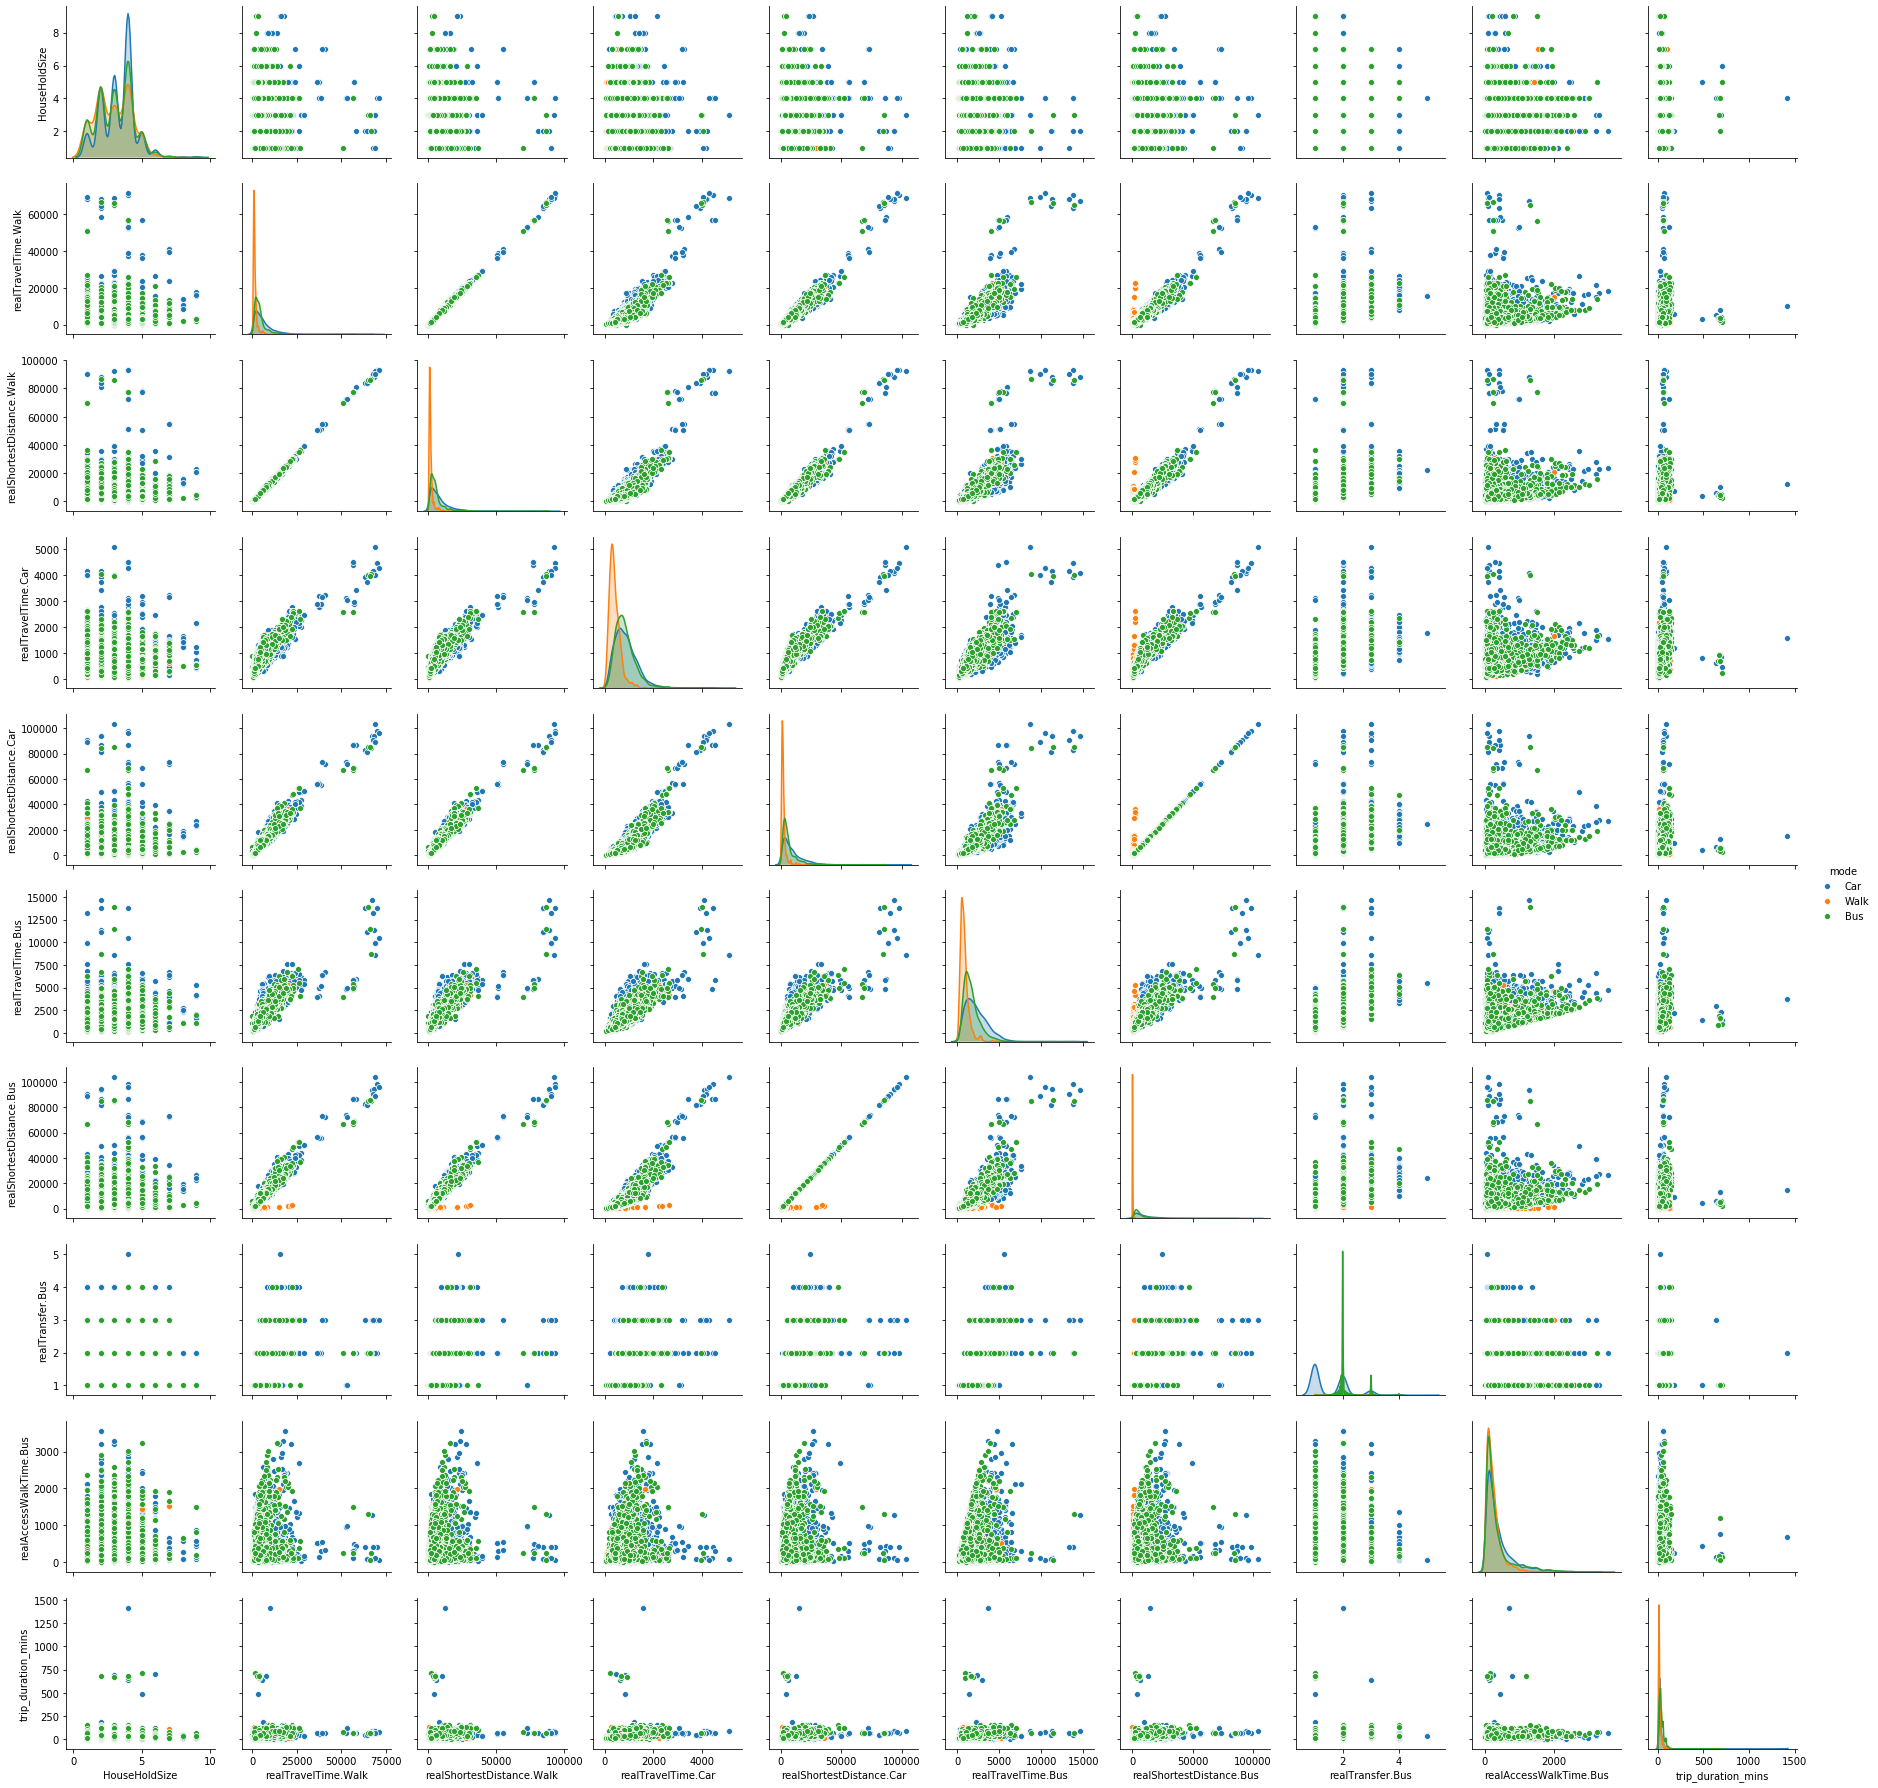

In [402]:
continuous_features = []
for col in df.columns:
    if df[col].dtype != 'object':
        continuous_features.append(col)

g = sns.pairplot(df_encoded[continuous_features], hue = 'mode')

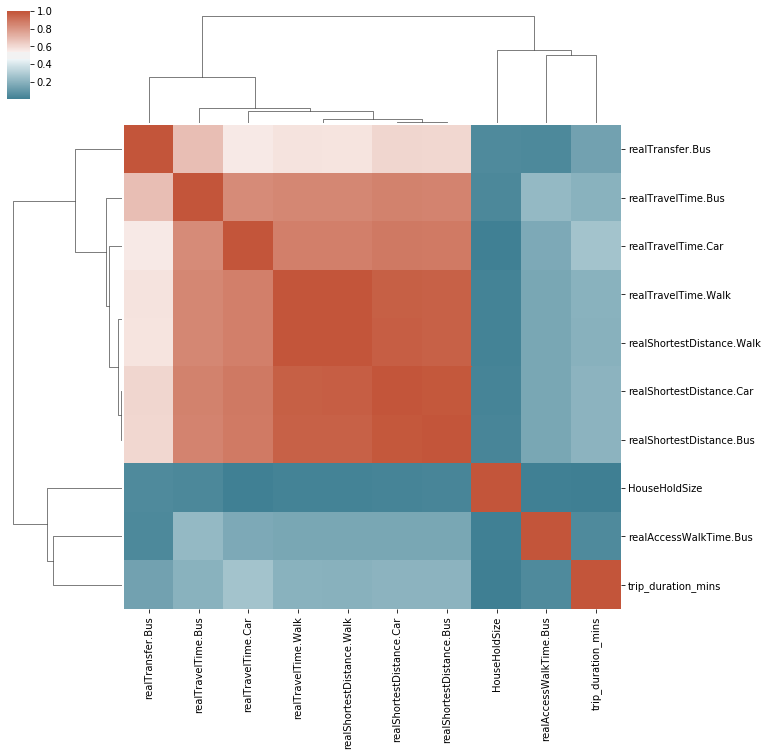

In [53]:
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
ax = sns.clustermap(df_encoded[continuous].corr(), figsize= (11,11), cmap = cmap).ax_row_dendrogram.set_visible(True)

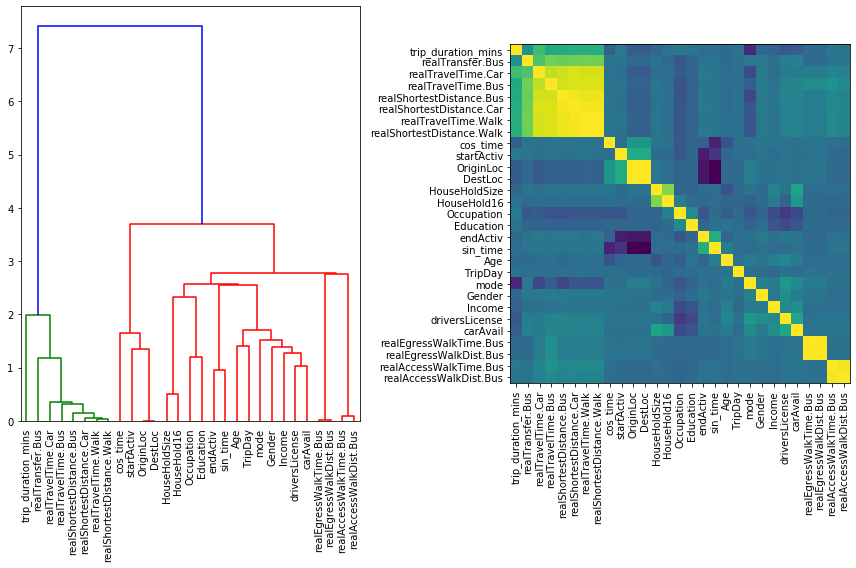

In [401]:
col_names = []

for col in df_encoded.columns: 
    col_names.append(col)

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(df_encoded).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=col_names, ax=ax[0],
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax[1].imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax[1].set_xticks(dendro_idx)
ax[1].set_yticks(dendro_idx)
ax[1].set_xticklabels(dendro['ivl'], rotation='vertical')
ax[1].set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

## Multinomial logit model

In [55]:
X_oh = df_one_hot.copy()
y_oh = X_oh['mode']
X_oh = X_oh.drop(['mode'], axis=1)

In [59]:
mn_logit = sm.discrete.discrete_model.MNLogit(y_oh, X_oh, method='newton')
result=mn_logit.fit_regularized(method='l1', maxiter=1000)
#print(result.summary())

invalid value encountered in true_divide
divide by zero encountered in log
invalid value encountered in multiply


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.33649899694228375
            Iterations: 86
            Function evaluations: 392
            Gradient evaluations: 86


We have some issues in that the solver cannot handle the sparsity of our one hot encoded features, we also have some near perfect seperation issues. Instead using label encoded data.

Running optimisation again with only significant features

In [365]:
X_sig = df_one_hot[['HouseHold16', 
                    'driversLicense',
                   'carAvail',
                   'realTravelTime.Car',
                   'realTravelTime.Bus',
                   'realTransfer.Bus',
                   'realAccessWalkDist.Bus',
                   'realAccessWalkTime.Bus',
                   'trip_duration_mins',
                   'sin_time',
                   'cos_time',
                   'realShortestDistance.Bus',
                   'mode']].copy()

y_sig = X_sig['mode']
X_sig = X_sig.drop(['mode'], axis=1)
X_sig['constant'] = 1

In [367]:
mn_logit = sm.discrete.discrete_model.MNLogit(y_sig, X_sig, method='newton')
result=mn_logit.fit_regularized(method='l1')
print(result.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.37568247691132967
            Iterations: 74
            Function evaluations: 280
            Gradient evaluations: 74
                          MNLogit Regression Results                          
Dep. Variable:                   mode   No. Observations:                 6609
Model:                        MNLogit   Df Residuals:                     6583
Method:                           MLE   Df Model:                           24
Date:                Sun, 24 May 2020   Pseudo R-squ.:                  0.6069
Time:                        19:32:08   Log-Likelihood:                -2482.9
converged:                       True   LL-Null:                       -6316.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                mode=Car       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

### Calculating predictive accuracy of logistic regression model on dataset

In [369]:
lr_params = {
  'multi_class': 'multinomial',
  'solver' : 'newton-cg'
}

clf_lr = LogisticRegression(multi_class='multinomial', max_iter=10000)

In [370]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_sig, y_sig, test_size=0.2, random_state=7)

In [371]:
clf_lr.fit(X_train_lr, y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [372]:
pred = clf_lr.predict(X_test_lr)
f1 = f1_score(y_test_lr, pred, average = 'micro')
print("F1 score for logistic regression is: " + str(f1))

F1 score for logistic regression is: 0.8411497730711044


In [375]:
def plot_matrix(clf, name, X_test, y_test):    
    
    """
    Function which plots both non-normalised and normalised confusion matrix
    clf: fitted classifier
    name: name of classifier for title plotting
    """
    
    target = ['Car', 'Bus', 'Walk']

    options = [("Raw confusion matrix " + name, None, '.0f'), 
               ("Normalised confusion matrix " + name, 'true', '.3f')]

    for title, normalize, values_format in options:

        cm = plot_confusion_matrix(clf, X_test, y_test,
                                     display_labels=target,
                                     cmap=plt.cm.Blues, 
                                     normalize=normalize,
                                     values_format =values_format)
        cm.ax_.set_title(title)

        print(title)
        print(cm.confusion_matrix)

Raw confusion matrix logistic regression
[[353 144   0]
 [ 66 599   0]
 [  0   0 160]]
Normalised confusion matrix logistic regression
[[0.71026157 0.28973843 0.        ]
 [0.09924812 0.90075188 0.        ]
 [0.         0.         1.        ]]


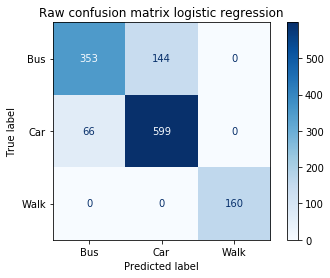

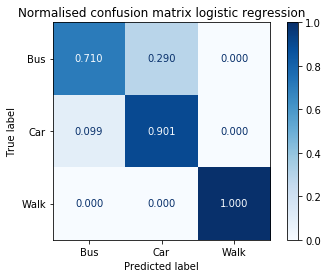

In [376]:
plot_matrix(clf_lr, 'logistic regression', X_test_lr, y_test_lr)

## Preparing datasets for XGBoost predictors

In [62]:
X_display = df.copy()
y_display = X_display['mode']
X_display = X_display.drop(['mode'], axis=1)

In [66]:
X.head(5)

,Income,Gender,Age,Occupation,Education,HouseHoldSize,HouseHold16,driversLicense,carAvail,OriginLoc,DestLoc,startActiv,endActiv,TripDay,realTravelTime.Walk,realShortestDistance.Walk,realTravelTime.Car,realShortestDistance.Car,realTravelTime.Bus,realShortestDistance.Bus,realTransfer.Bus,realAccessWalkTime.Bus,realAccessWalkDist.Bus,realEgressWalkTime.Bus,realEgressWalkDist.Bus,trip_duration_mins,sin_time,cos_time
0,1,1,1,4,2,5,5,1,1,4,5,9,3,1,1505,1973,297,2271,964,2271,1,183,211,355,463,20,-0.751840,0.659346
1,1,0,2,0,1,5,2,1,1,2,3,15,9,0,4235,5931,1126,6651,2133,6651,1,1826,6542,307,411,20,-0.707107,-0.707107
2,0,1,5,2,3,3,3,1,1,1,2,3,2,5,1476,2234,454,2657,1183,2657,1,94,134,626,843,10,0.500000,-0.866025
3,1,0,4,2,0,2,2,1,1,2,3,13,6,0,640,853,331,1671,454,331,1,283,738,171,238,20,-0.043619,-0.999048
4,4,0,3,0,0,4,2,1,1,4,5,13,3,2,1231,1357,425,2034,738,2034,1,180,221,34,60,10,-0.843391,0.537300


In [67]:
X_display.head(5)

,Income,Gender,Age,Occupation,Education,HouseHoldSize,HouseHold16,driversLicense,carAvail,OriginLoc,DestLoc,startActiv,endActiv,TripDay,realTravelTime.Walk,realShortestDistance.Walk,realTravelTime.Car,realShortestDistance.Car,realTravelTime.Bus,realShortestDistance.Bus,realTransfer.Bus,realAccessWalkTime.Bus,realAccessWalkDist.Bus,realEgressWalkTime.Bus,realEgressWalkDist.Bus,trip_duration_mins,sin_time,cos_time
0,10000-20000,Male,25-34,Unemployed,HighSchool,5,5,1,1,4,5,PersonalActivities,Home,Monday,1505,1973,297,2271,964,2271,1,183,211,355,463,20,-0.751840,0.659346
1,10000-20000,Female,35-44,Employed,Lyceum,5,2,1,1,2,3,Work,PersonalActivities,Friday,4235,5931,1126,6651,2133,6651,1,1826,6542,307,411,20,-0.707107,-0.707107
2,<10000,Male,65+,Retired,PrimarySchool,3,3,1,1,1,2,Home,HealthActivities,Tuesday,1476,2234,454,2657,1183,2657,1,94,134,626,843,10,0.500000,-0.866025
3,10000-20000,Female,55-64,Retired,University,2,2,1,1,2,3,Shopping,Leisure,Friday,640,853,331,1671,454,331,1,283,738,171,238,20,-0.043619,-0.999048
4,40000-50000,Female,45-54,Employed,University,4,2,1,1,4,5,Shopping,Home,Saturday,1231,1357,425,2034,738,2034,1,180,221,34,60,10,-0.843391,0.537300


In [65]:
X = df_encoded.copy()
y = X['mode']
X = X.drop(['mode'], axis=1)

In [68]:
labels = {
    'Car': 0,
    'Bus': 1,
    'Walk' : 2
}

In [69]:
y = y.map(labels)

In [70]:
xgb_full = xgb.DMatrix(X, label=y)

Series.base is deprecated and will be removed in a future version


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

## Single DT

In [72]:
clf_dt = tree.DecisionTreeClassifier(max_depth=3)  
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [73]:
pred = clf_dt.predict(X_test)
f1 = f1_score(y_test, pred, average = 'micro')
print("F1 score for decision tree is: " + str(f1))

F1 score for decision tree is: 0.7783661119515886


Raw confusion matrix decision tree
[[532 132   1]
 [148 348   1]
 [  5   6 149]]
Normalised confusion matrix decision tree
[[0.8        0.19849624 0.00150376]
 [0.29778672 0.70020121 0.00201207]
 [0.03125    0.0375     0.93125   ]]


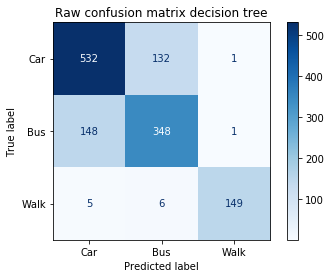

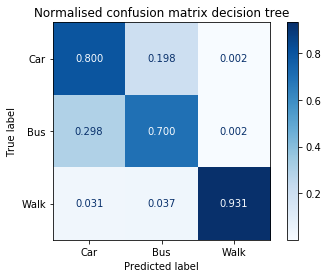

In [76]:
plot_matrix(clf_dt, 'decision tree', X_test, y_test)

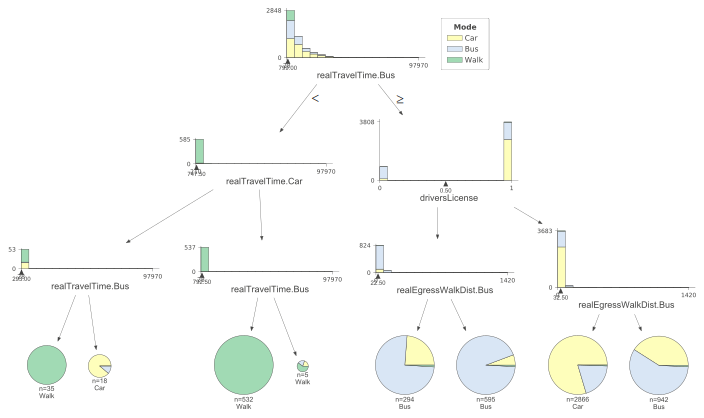

In [477]:
viz = dtreeviz(clf_dt, 
               X_train,
               y_train,
               target_name='Mode',
               feature_names=col_names,
               class_names=["Car", "Bus", "Walk"],
               scale=(1),
               orientation='TD',
               histtype= 'barstacked') 
viz

## XGBOOST

### Hyperparam tuning

In [78]:
#search space

params_xgboost = {
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
 'n_estimators'     : [24],
 'objective': 'multi:softmax' 
}

In [79]:
clf_HT = XGBClassifier()

In [80]:
random_search = RandomizedSearchCV(estimator = clf_HT, 
                      param_distributions = params_xgboost, 
                      n_iter = 50, 
                      cv = 5, 
                      verbose=1, 
                      random_state=2,
                      scoring = 'f1_micro', 
                      n_jobs = 1)

In [81]:
random_search.fit(X, y)
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.7min finished


Best: 0.884099 using {'objective': 'o', 'n_estimators': 24, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.7}


In [ ]:
#means = random_search.cv_results_['mean_test_score']
#stds = random_search.cv_results_['std_test_score']
#params = random_search.cv_results_['params']

#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

### Training and predicting with XGboost (using both XGboost objects and df's for ease of plotting), with early stopping

In [82]:
params = {    
'colsample_bytree': 0.7,
'gamma': 0.1,
'learning_rate': 0.3,
'max_depth': 10,
'min_child_weight': 5,
'num_class': 3,
'objective': 'multi:softmax'
}

model_train = xgb.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000, early_stopping_rounds=500)

[0]	test-merror:0.220877
Will train until test-merror hasn't improved in 500 rounds.
Stopping. Best iteration:
[20]	test-merror:0.109682



In [85]:
clf_xg = XGBClassifier(colsample_bytree = 0.7,
                      gamma = 0.1,
                      learning_rate = 0.3,
                      max_depth = 10,
                      min_child_weight = 5,
                      num_class = 3,
                      objective = 'multi:softmax',
                      n_estimators = 20)
clf_xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1,
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=5, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [83]:
y_pred = model_train.predict(xgb_test, ntree_limit=model_train.best_ntree_limit)

In [84]:
f1 = f1_score(y_test, y_pred, average = 'micro')
print("XGboost f1 score is %.3f: " % f1)

XGboost f1 score is 0.890: 


Raw confusion matrix XGBoost
[[601  64   0]
 [ 80 416   1]
 [  1   1 158]]
Normalised confusion matrix XGBoost
[[0.9037594  0.0962406  0.        ]
 [0.16096579 0.83702213 0.00201207]
 [0.00625    0.00625    0.9875    ]]


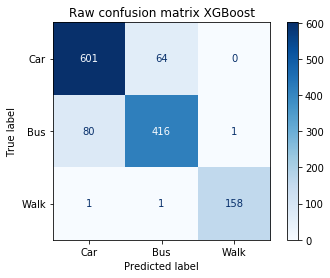

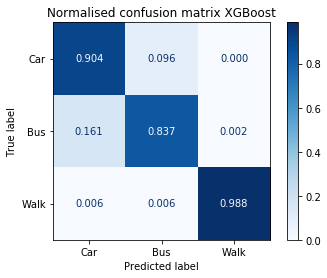

In [86]:
plot_matrix(clf_xg, 'XGBoost', X_test, y_test)

## XGboost feature importance

Since we have found good params and validated on test set, we will now train an XGboost model on the full dataset. Since we are no longer interested in prediction, we have no validation set. 

In [87]:
XGB_FULL = xgb.train(params, xgb_full, 20)

In [88]:
#Saving model weights
joblib.dump(XGB_FULL, 'XG_FULL') 

['XG_FULL']

In [148]:
#test = joblib.load('XG_FULL')

In [399]:
def plot_feature_importance(type, num):
    
    """
    type: either; gain, total_gain, weight or total_cover
    num: the number of features to plot
    """

    score = pd.Series(XGB_FULL.get_score(importance_type=type))
    sorted_ix = score.abs().sort_values().index
    
    if type == 'weight':
        type = 'F-Score'
    else:
        type == type

    fig, ax = plt.subplots(figsize=(10,6))

    ax = score[sorted_ix][-num:].plot(kind='barh', color='dodgerblue', alpha = 0.8)
    ax.set_title(type + ' feature importance XGBoost')
    plt.show()

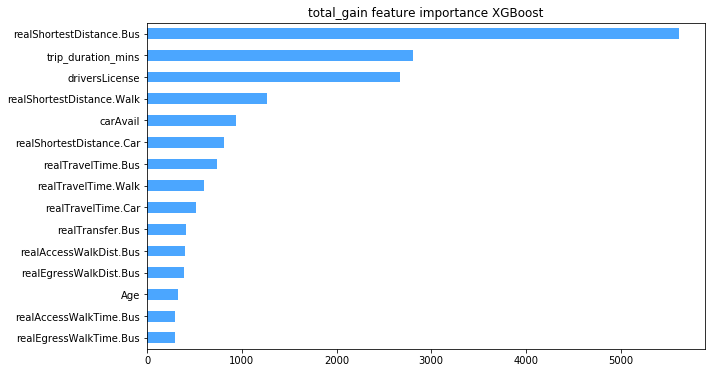

In [400]:
plot_feature_importance('total_gain', 15)

A better approach to global feature importance is to run permutation or 'drop one' importance, however, we have colinear features, meaning we would have to drop a number of features at once, making the exercise less meaningful

## SHAP values

In [91]:
shap_values = shap.TreeExplainer(XGB_FULL).shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [92]:
explainer = shap.TreeExplainer(XGB_FULL)
expected_value = explainer.expected_value

Shap summary values for all classes

In [93]:
print(X_display.columns)

Index(['Income', 'Gender', 'Age', 'Occupation', 'Education', 'HouseHoldSize',
       'HouseHold16', 'driversLicense', 'carAvail', 'OriginLoc', 'DestLoc',
       'startActiv', 'endActiv', 'TripDay', 'realTravelTime.Walk',
       'realShortestDistance.Walk', 'realTravelTime.Car',
       'realShortestDistance.Car', 'realTravelTime.Bus',
       'realShortestDistance.Bus', 'realTransfer.Bus',
       'realAccessWalkTime.Bus', 'realAccessWalkDist.Bus',
       'realEgressWalkTime.Bus', 'realEgressWalkDist.Bus',
       'trip_duration_mins', 'sin_time', 'cos_time'],
      dtype='object')


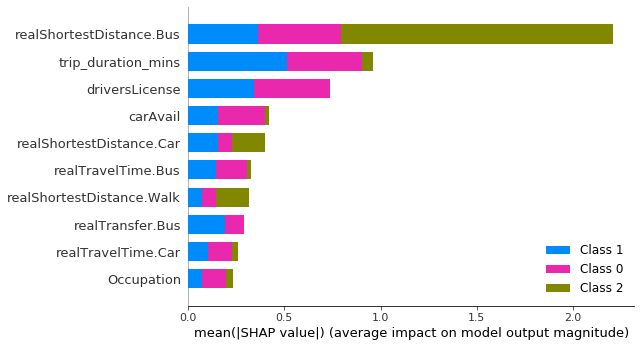

In [94]:
shap.summary_plot(shap_values, X, plot_type = 'bar', max_display=10)

Shap summary values for car

In [95]:
def plot_summary(type, max):
    
    if type == 'Car':
        type = shap_values[0]
    elif type == 'Bus':
        type = shap_values[1]
    elif type == 'Walk':
        type = shap_values[2]
    else:
        print('invalid type')
           
    shap.summary_plot(type, X, max_display=max, alpha=0.5, plot_type = 'violin')

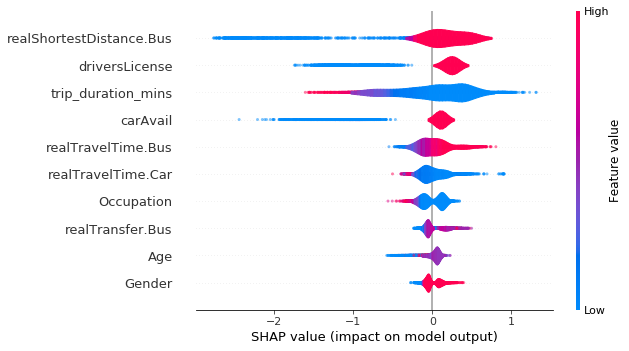

In [96]:
plot_summary('Car', 10)

Shap summary values for bus

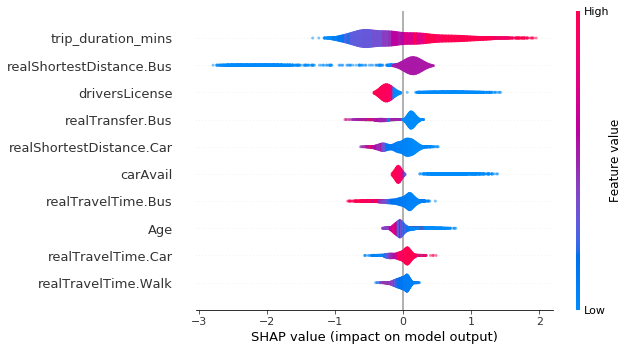

In [97]:
plot_summary('Bus', 10)

Shap summary values for walk

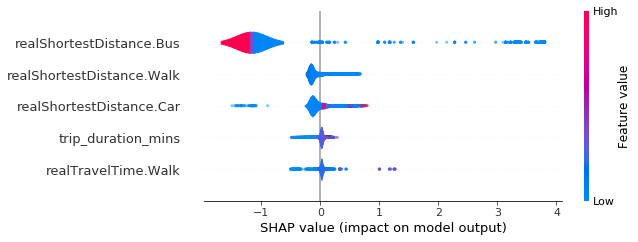

In [98]:
plot_summary('Walk', 5)

In [439]:
def dependence_plot(feature, mode, percentile, index = None, jitter = None):
    
    if mode == 'Car':
        mode = shap_values[0]
    elif mode == 'Bus':
        mode = shap_values[1]
    elif mode == 'Walk':
        mode = shap_values[2]
    else:
        mode = shap_values[0]
    
    fig, ax = plt.subplots(figsize=(12,6))

    shap.dependence_plot(
    (feature),
    mode, X,
    display_features=X_display,
    xmax = 'percentile('+str(percentile)+')',
    alpha = 0.7,
    interaction_index=index,
    x_jitter = jitter,
    ax=ax
    )

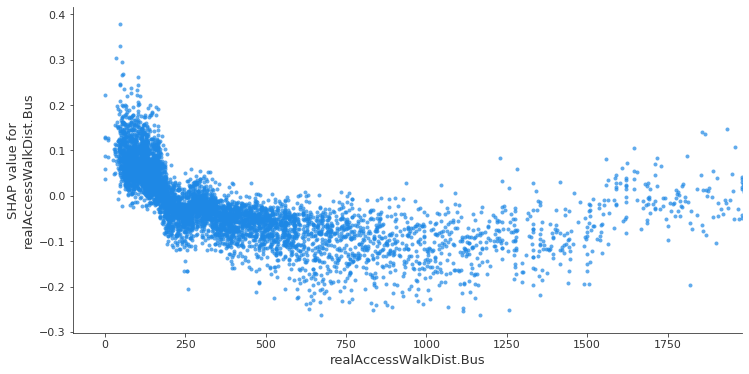

In [425]:
dependence_plot("realAccessWalkDist.Bus", 'Bus', 90, index = None, jitter = 0)

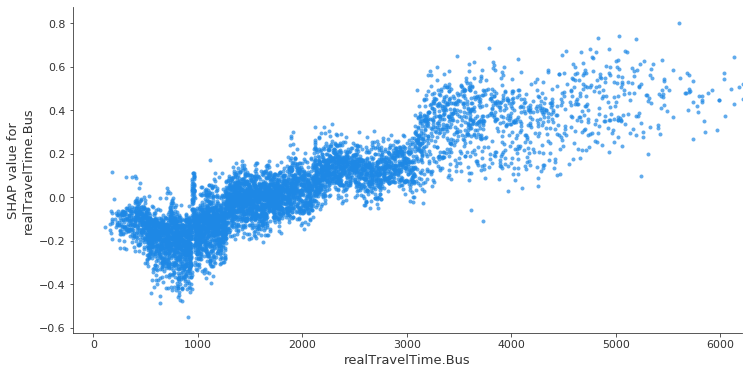

In [426]:
dependence_plot("realTravelTime.Bus", 'Car', 99.5, index = None, jitter = 0)

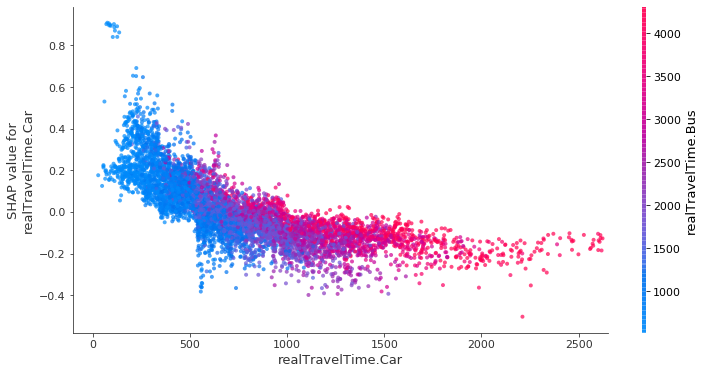

In [428]:
dependence_plot("realTravelTime.Car", 'Car', 99.6, index = 'realTravelTime.Bus', jitter = 0)

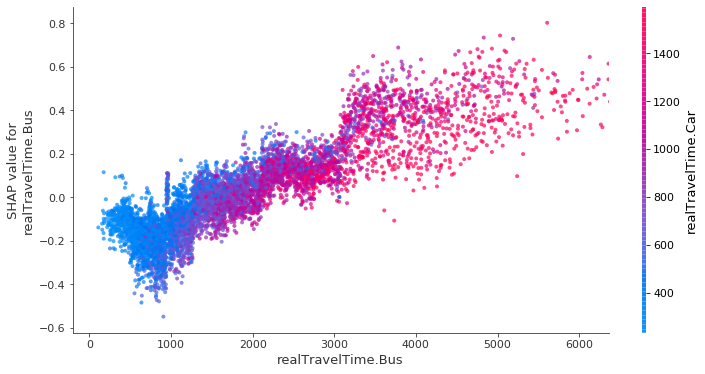

In [430]:
dependence_plot("realTravelTime.Bus", 'Car', 99.6, index = 'realTravelTime.Car', jitter = 0)

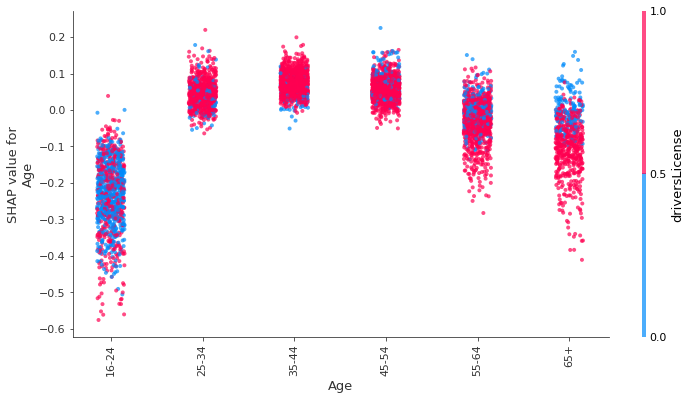

In [432]:
dependence_plot("Age", 'Car', 100, index = 'driversLicense', jitter = 0.3)

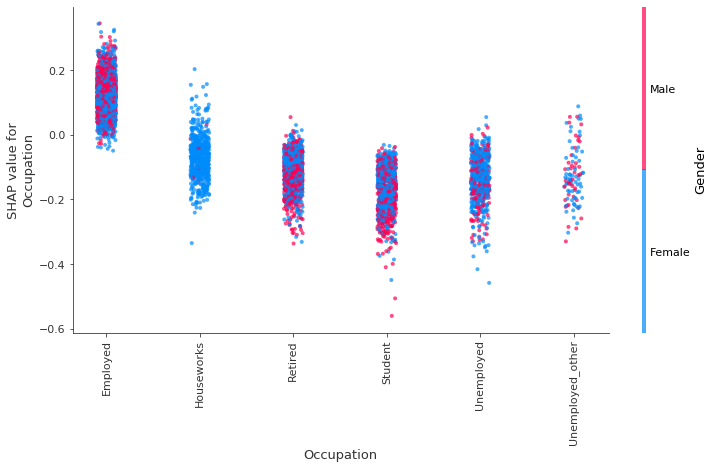

In [433]:
dependence_plot("Occupation", 'Car', 100, index = 'Gender', jitter = 0.2)

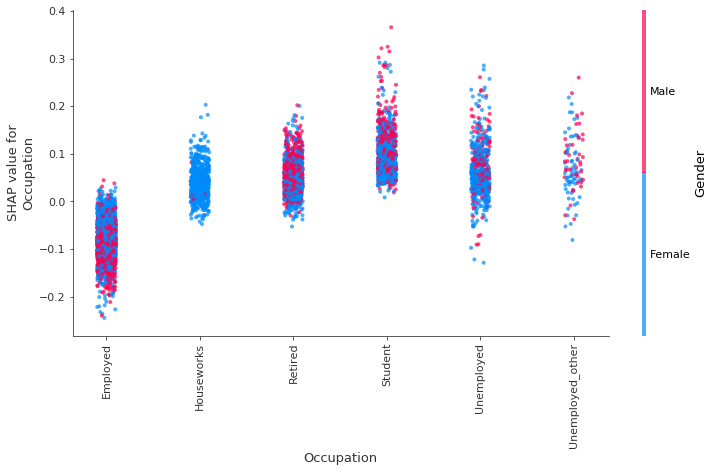

In [434]:
dependence_plot("Occupation", 'Bus', 100, index = 'Gender', jitter = 0.2)

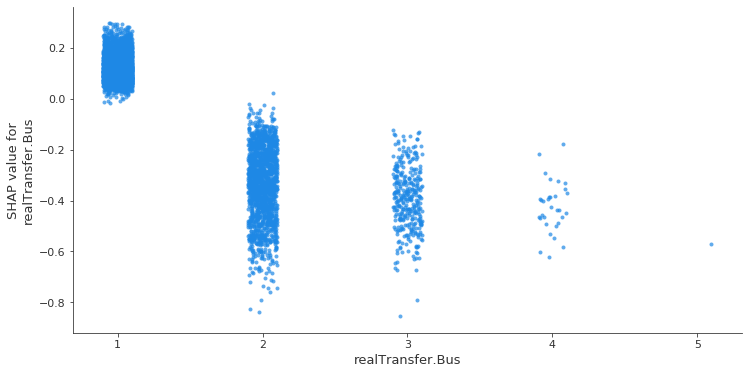

In [435]:
dependence_plot("realTransfer.Bus", 'Bus', 100, index = None, jitter = 0.2)

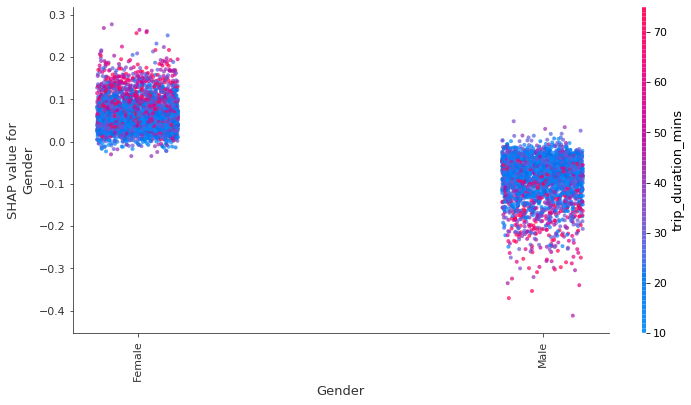

In [438]:
dependence_plot("Gender", 'Bus', 100, index = 'trip_duration_mins', jitter = 0.2)

In [115]:
#plotting top 10 for car
#for i in range(22):
#    shap.dependence_plot("rank(%d)" % i, shap_values[0], X, display_features=X_display, xmax = 'percentile(99)')

In [117]:
#plotting top 10 for bus
#for i in range(22):
#    shap.dependence_plot("rank(%d)" % i, shap_values[1], X, display_features=X_display,xmax = 'percentile(99)')

In [546]:
#plotting top 10 for bus
#for i in range(18):
#    shap.dependence_plot("rank(%d)" % i, shap_values[2], X, display_features=X_display,xmax = 'percentile(99)')

In [118]:
shap_interaction_values = shap.TreeExplainer(XGB_FULL).shap_interaction_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


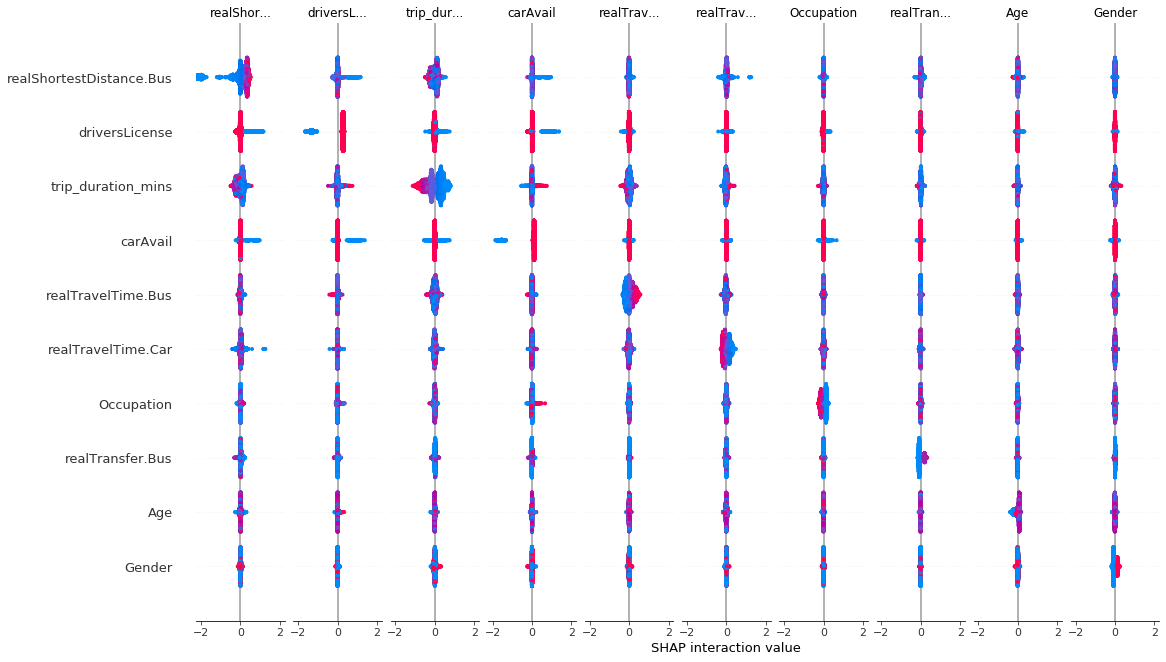

In [405]:
shap.summary_plot(shap_interaction_values[0], X, max_display=10)

In [472]:
def interaction_plot(feature_1, feature_2, mode, percentile, jitter):
    
    """
    Function which plots the interaction effects of two features
    feature_1: first feature of interest
    feature_2: second feature of interest
    mode: travel mode of interest
    percentile: x_max entent of plot (confidence interval)
    jitter: x jitter for asthetics for categorical variables 
    """
    
    fig, ax = plt.subplots(figsize=(10,6))

    if mode == 'Car':
        mode = shap_interaction_values[0]
    elif mode == 'Bus':
        mode = shap_interaction_values[1]
    elif mode == 'Walk':
        mode = shap_interaction_values[2]
    else:
        mode = shap_interaction_values[0]
    
    shap.dependence_plot(
    (feature_1, feature_2),
    mode, X,
    display_features=X_display,
    xmax = 'percentile('+str(percentile)+')',
    x_jitter = jitter,
    alpha = 0.7,
    ax=ax
    )

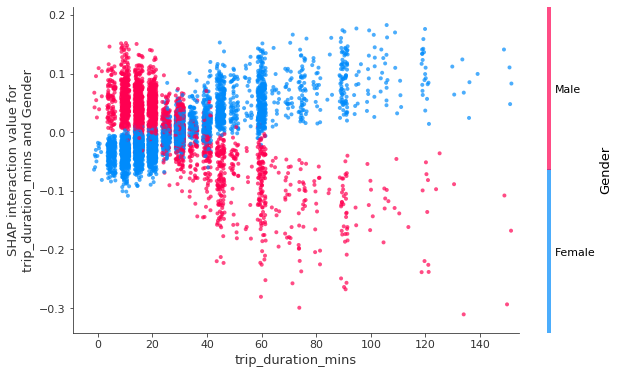

In [442]:
interaction_plot("trip_duration_mins", "Gender", 'Bus', 99.82, 0.6)

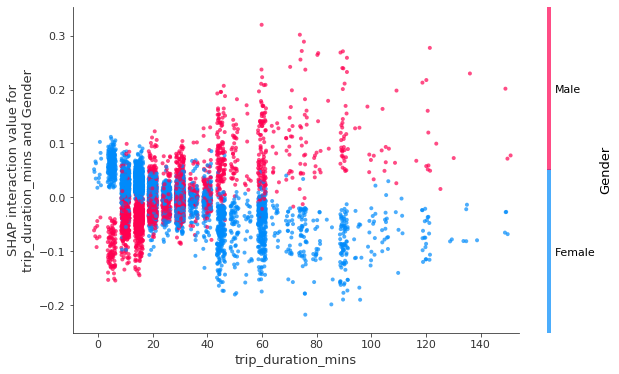

In [443]:
interaction_plot("trip_duration_mins", "Gender", 'Car', 99.82, 0.6)

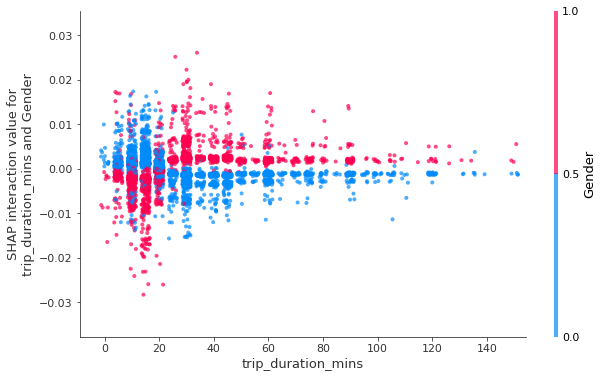

In [427]:
interaction_plot("trip_duration_mins", "Gender", 'Walk', 99.82, 0.6)

Indexing a female in our dataset to run a SHAP style sensitivity analyis 

In [180]:
idx = 4020
X_display.loc[idx]

Income                             ÄÎ/ÄÁ
Gender                            Female
Age                                16-24
Occupation                       Student
Education                         Lyceum
HouseHoldSize                          2
HouseHold16                            2
driversLicense                         1
carAvail                               0
OriginLoc                              1
DestLoc                                2
startActiv                          Home
endActiv                          School
TripDay                         Saturday
realTravelTime.Walk                 1163
realShortestDistance.Walk           1565
realTravelTime.Car                   355
realShortestDistance.Car            2026
realTravelTime.Bus                   745
realShortestDistance.Bus             355
realTransfer.Bus                       1
realAccessWalkTime.Bus               242
realAccessWalkDist.Bus               359
realEgressWalkTime.Bus               180
realEgressWalkDi

In [467]:
def synthetic_plot(left, right, interval, mode, feature, jitter, order):
    
    """
    Fixes all SHAP feature values for specific training example/individual but generates 
    synthetic data over a range for feature of interest (this can be seen as 
    a form of sensitivity analysis). Then plots results.
    left: start of data generation range
    right: end of data generation range
    interval: data interval for synthetic data
    mode: travel mode of interest
    feature: feature of interest
    jitter: jitter to apply to plot for asthetics 
    order: order of polynomial fit for plotting 
    """
    
    if mode == 'Car':
        mode = 0
    elif mode == 'Bus':
        mode = 1
    elif mode == 'Walk':
        mode = 2
    else:
        mode = 0
    
    rg = range(left, right, interval)
    R = X.iloc[np.repeat(idx, len(rg))].reset_index(drop=True)
    R[feature] = rg

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        hypothetical_shap_values = explainer.shap_values(R)[mode]
    
    hypothetical_predictions = expected_value[mode] + hypothetical_shap_values.sum(axis=1)
    hypothetical_predictions = 1 / (1 + np.exp(-hypothetical_predictions))

    loc = R.columns.get_loc(feature)

    fig, ax = plt.subplots(figsize=(10,6))

    sns.regplot(x= R[feature], y= hypothetical_shap_values[:, loc], 
                truncate = True, 
                order = order, 
                ci=False, 
                line_kws = {'alpha':0.3}, 
                scatter = True, 
                y_jitter=jitter,
                color = 'dodgerblue',
                scatter_kws={'linewidths':1,'edgecolor':'k'})

    plt.axvline(X_display[feature].loc[idx], ls='--', c='red', alpha=0.6, label='Current value for individual')
    plt.axhline(0, ls='--', c='green', alpha=0.6, label='Threshold positive/negative contribution')
    
    if mode == 0:
        mode = 'Car'
    elif mode == 1:
        mode = 'Bus'
    elif mode == 2:
        mode = 'Walk'

    ax.set_ylabel('SHAP value contribution to positive prediction ' + mode + ' travel mode')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()

    plt.show()

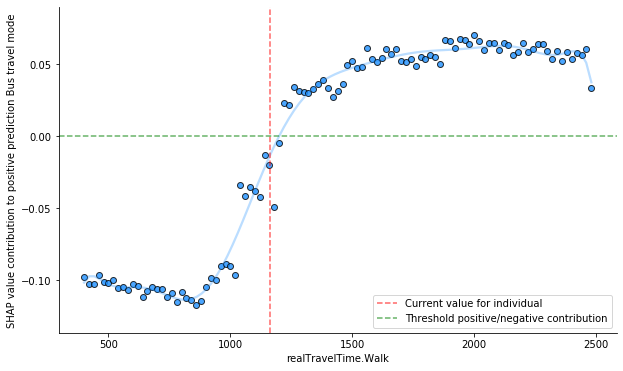

In [471]:
synthetic_plot(400, 2500, 20, 'Bus', 'realTravelTime.Walk', 0.005, 12)

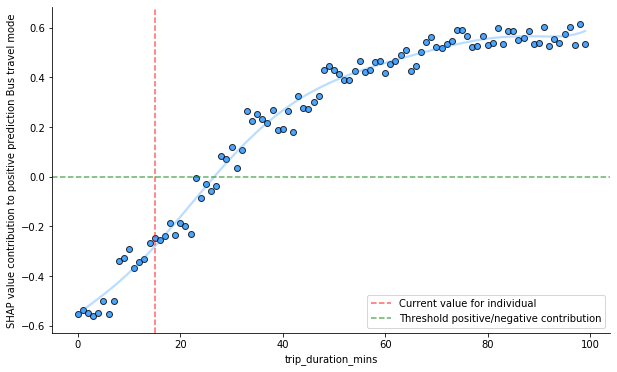

In [469]:
synthetic_plot(0, 100, 1, 'Bus', 'trip_duration_mins', 0.05, 8)

For this specific individual, we can plot the features which most contribute to a positive prediction for each class. Transformed to logit probability. 

In [183]:
shap.initjs()

In [197]:
shap.force_plot(expected_value[0], shap_values[0][4020,:], X.iloc[4020,:], link="logit")

In [391]:
shap.force_plot(expected_value[1], shap_values[1][4020,:], X.iloc[4020,:], link="logit")

In [199]:
shap.force_plot(expected_value[2], shap_values[2][4020,:], X.iloc[4020,:], link="logit")